In [5]:
import pandas as pd 

file_path = '/Users/laurensalapong/Downloads/pittsburgh_parks.csv' 
df = pd.read_csv(file_path) 

#Get rid of unnecessary columns
df.drop(columns = ['_id', 'id', 'maintenance_responsibility', 'image', 'council_district', 'ward', 'tract', 'public_works_division', 'pli_division', 'police_zone', 'fire_zone'], inplace = True)

#Sets the dataframe to only include data from 'type' column that = 'park'
parks_only = df[df['type'].str.lower() == 'park'] 

#Group by neughborhood and count the number of parks in each neighborhood
parks_per_neighborhood = parks_only.groupby('neighborhood')['type'].count().reset_index() 

#Rename columns
parks_per_neighborhood.columns = ['Neighborhood', 'Number_of_Parks'] 

#Sort neighborhoods by number of parks in descending order
parks_per_neighborhood = parks_per_neighborhood.sort_values(by='Number_of_Parks', ascending=False) 

         Neighborhood  Number_of_Parks
55  South Side Slopes                6
5           Beechview                6
43   Mount Washington                5
30          Hazelwood                5
64          Troy Hill                5
..                ...              ...
34      Homewood West                1
41        Middle Hill                1
42        Morningside                1
44      New Homestead                1
70            Windgap                1

[71 rows x 2 columns]


Matplotlib is building the font cache; this may take a moment.


           neighborhood  Green_Space_Ratio Total_Park_Area_formatted  \
80  Squirrel Hill South          60.911715            4,220,480 sq m   
25                 Hays          57.218978            2,584,825 sq m   
36        Highland Park          51.156966            1,549,230 sq m   
45     Allegheny Center          47.794672              258,498 sq m   
9      Duquesne Heights          43.566357              698,702 sq m   
15          Perry North          33.602822            1,052,425 sq m   
26          Beltzhoover          30.148155              324,183 sq m   
30            Allentown          17.318780              133,149 sq m   
48    South Side Slopes          16.909139              316,493 sq m   
60            Hazelwood          15.331593              637,091 sq m   

   neighborhood_area_formatted  
80              6,928,848 sq m  
25              4,517,426 sq m  
36              3,028,386 sq m  
45                540,852 sq m  
9               1,603,765 sq m  
15       

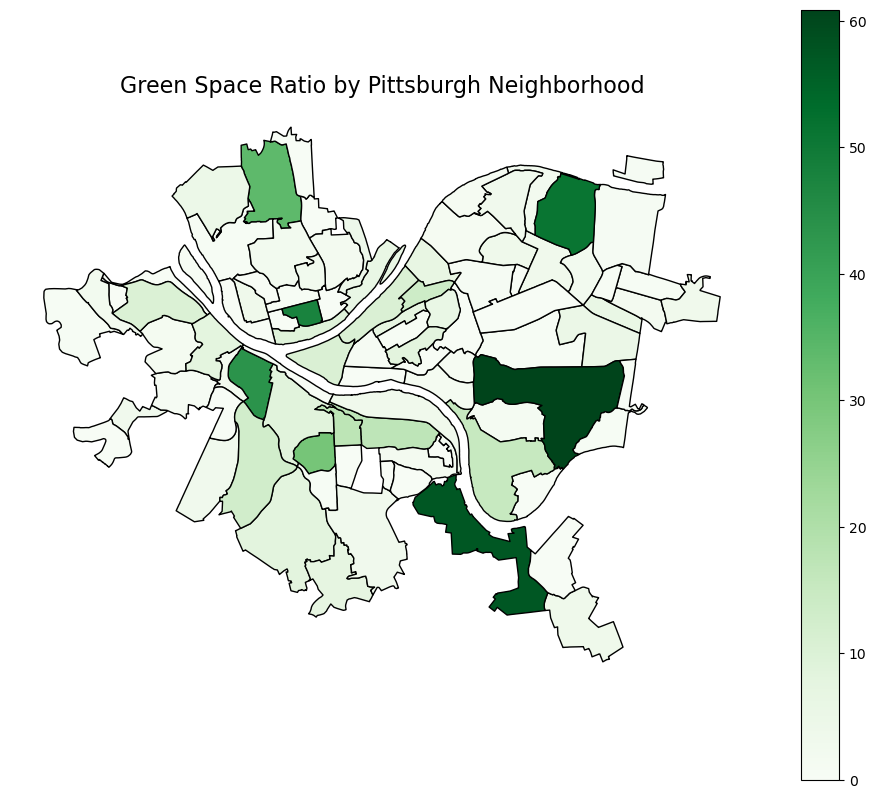

In [3]:
import geopandas as gpd
import matplotlib.pyplot as plt

#Load JSON files from Western Pennsylvania Regional Data Center
neighborhoods = gpd.read_file('https://data.wprdc.org/dataset/e672f13d-71c4-4a66-8f38-710e75ed80a4/resource/4af8e160-57e9-4ebf-a501-76ca1b42fc99/download/neighborhoods.geojson')
parks_geo = gpd.read_file('https://data.wprdc.org/dataset/e298e2ae-07c0-4aa4-a2ca-2c8db845b552/resource/ca4ee6a6-3058-487f-9724-2a335b2d79f2/download/parks.geojson')

#Rename column for readability
neighborhoods.rename(columns={'hood': 'neighborhood'}, inplace=True)

#Convert to a CRS (Coordinate Reference System - round map to flat map) that preserves correct area (UTM Zone 17N for Pittsburgh)
neighborhoods = neighborhoods.to_crs(epsg=32617)
parks_geo = parks_geo.to_crs(epsg=32617)

#Calculate areas in square meters
neighborhoods['neighborhood_area'] = neighborhoods.geometry.area
parks_geo['park_area'] = parks_geo.geometry.area

#Create centroids of parks to assign each park to ONE neighborhood
parks_geo['centroid'] = parks_geo.geometry.centroid

#Temporarily set geometry to centroid for the spatial join
parks_centroids = parks_geo.set_geometry('centroid')

#Spatial join using centroids (each park assigned to only one neighborhood)
parks_with_neighborhood = gpd.sjoin(parks_centroids, neighborhoods, how='left', predicate='within')

#Sum up park areas by neighborhood
park_area_per_neighborhood = parks_with_neighborhood.groupby('neighborhood')['park_area'].sum().reset_index()
park_area_per_neighborhood.columns = ['Neighborhood', 'Total_Park_Area']

#Merge with neighborhood areas
neighborhood_totals = neighborhoods[['neighborhood', 'neighborhood_area']]
result = neighborhood_totals.merge(park_area_per_neighborhood, left_on='neighborhood', right_on='Neighborhood', how='left')

#Fill NaN values (neighborhoods with no parks) with 0
result['Total_Park_Area'] = result['Total_Park_Area'].fillna(0)

#Calculate the ratio (as a percentage)
result['Green_Space_Ratio'] = (result['Total_Park_Area'] / result['neighborhood_area']) * 100

#Sort by green space ratio
result = result.sort_values(by='Green_Space_Ratio', ascending=False)

#Define a function that formats a number with "sq m"
def format_area(number):
    return f"{number:,.0f} sq m"

#Apply the function to format the area columns
result['Total_Park_Area_formatted'] = result['Total_Park_Area'].apply(format_area)
result['neighborhood_area_formatted'] = result['neighborhood_area'].apply(format_area)

#Display with formatted columns
print(result[['neighborhood', 'Green_Space_Ratio', 'Total_Park_Area_formatted', 'neighborhood_area_formatted']].head(10))

# Create a choropleth map showing green space ratio
fig, ax = plt.subplots(figsize=(12, 10))

# Merge result back with neighborhoods for mapping
neighborhoods_with_ratio = neighborhoods.merge(result[['neighborhood', 'Green_Space_Ratio']], 
                                                left_on='neighborhood', 
                                                right_on='neighborhood')

# Plot
neighborhoods_with_ratio.plot(column='Green_Space_Ratio', 
                               cmap='Greens', 
                               legend=True,
                               edgecolor='black',
                               ax=ax)
plt.title('Green Space Ratio by Pittsburgh Neighborhood', fontsize=16)
plt.axis('off')
plt.show()

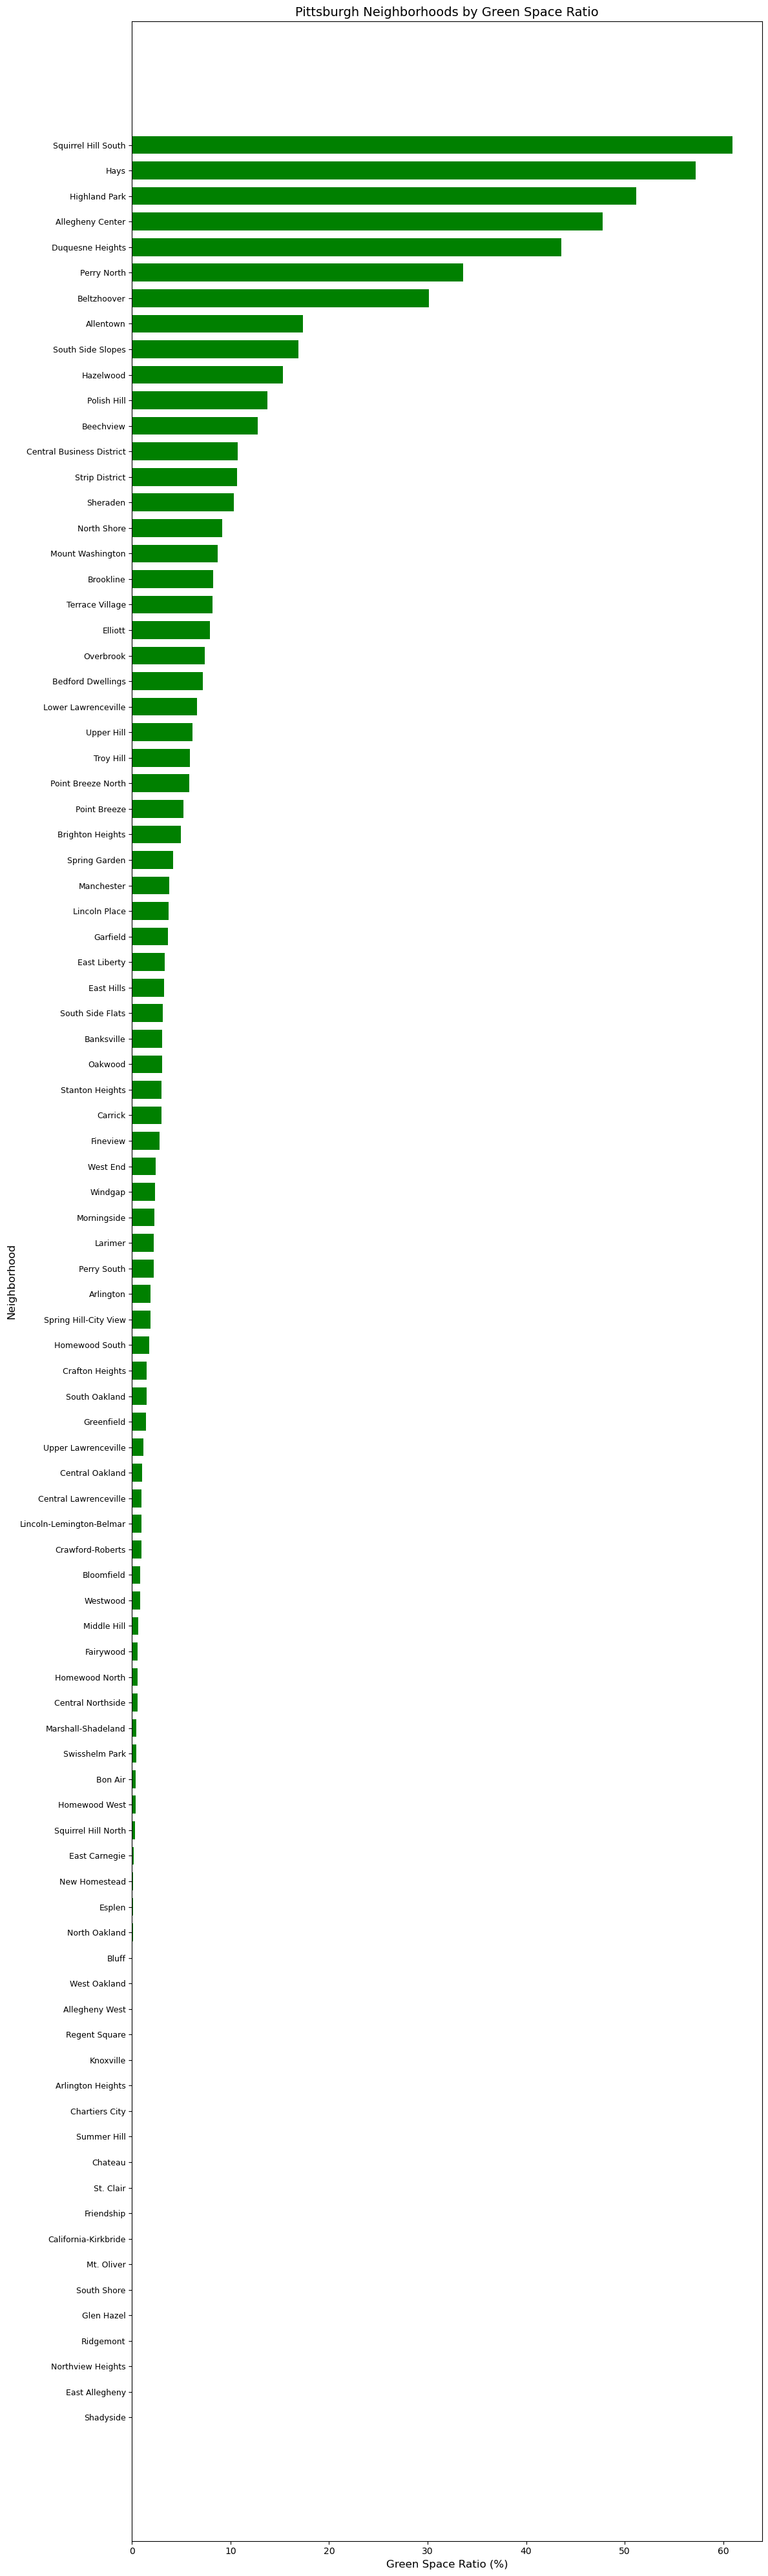

In [8]:
import matplotlib.pyplot as plt

#All neighborhoods sorted by green space ratio
plt.figure(figsize=(12, 40))
plt.barh(result['neighborhood'], result['Green_Space_Ratio'], color='green', height=0.7)
plt.xlabel('Green Space Ratio (%)', fontsize=12)
plt.ylabel('Neighborhood', fontsize=12)
plt.title('Pittsburgh Neighborhoods by Green Space Ratio', fontsize=14)
plt.yticks(fontsize=9)
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()